# Session 1 - A first look at Neural Networks

In this session we implement a fully connected Neural Network by hand. We will only use Numpy to handle the tensors. We do the backpropagation by hand given a cross entropy loss function.

All packages used over the next few days can be installed with

```console
pip install -r requirements.txt
```

We will train the neural network on the problem of whether a given line bundle has slope zero somewhere in the Kähler cone.

In [1]:
import numpy as np

## The NN implementation

We recall a Neural Network acts by iteratively applying matrix multiplications with subsequent non linearites:

$$
z_{i+1} = \sigma( W_i \cdot z_{i} + b_i)
$$

For our initial network we want to study a classification problem with two Classes. Since, this is a classification problem we make use of the softmax activation function in the last layer. Furthermore, we also want to have the option to use the ReLU and sigmoid activation functions in the intermediate layers:

$$
\text{softmax} (x_i) = p(x_i) = \frac{e^{x_i}}{\sum_i e^{x_i}}.
$$
and
$$
\text{relu} (x) = \begin{cases}
x \text{ if } x > 0 \\
0 \text{ else}
\end{cases}
$$
and
$$
\text{sigmoid} (x) = \frac{1}{1+e^{-x}}.
$$

Let's get started by implementing the neural network class:

In [2]:
class NN:
    def __init__(self, nInput, nLayer, nClasses, nHidden, activation):
        
        shapes = [nInput] + [nHidden for _ in range(nLayer)] + [nClasses]
        self.b = [np.zeros(shapes[i+1]) for i in range(nLayer+1)]
        self.W = [np.zeros((shapes[i], shapes[i+1])) for i in range(nLayer+1)]
        self.act = [activation for _ in range(nLayer)] + ['softmax'] 
        self.nLayer = nLayer+1
        self.nClasses = nClasses
        self.init_weights()
        
    def init_weights(self,mu = 0, sigma = 0.2):
        for i in range(self.nLayer):
            self.W[i] = np.random.normal(mu, sigma, np.shape(self.W[i]))
            self.b[i] = np.random.normal(mu, sigma, np.shape(self.b[i]))

    def sigmoid(self, x):
        return 1/(1+np.exp(-1*x))
    
    def relu(self, x):
        return np.where(x > 0, x, 0)
    
    def forward(self, x, i):
        return np.dot(x, self.W[i]) + self.b[i]
    
    def act_forward(self, x, act):
        return act(x)
    
    def softmax(self, x):
        # introuce numerical stability
        x_stable = x-np.max(x)
        e = np.exp(x_stable)
        s = np.multiply(e, np.reshape(1/np.sum(e, axis=1), (x.shape[0],1)))
        return s
    
    def activation(self, i):
        if self.act[i] == 'relu':
            return self.relu
        elif self.act[i] == 'sigmoid':
            return self.sigmoid
        elif self.act[i] == 'softmax':
            return self.softmax
        
    def predict(self, x, train = True):
        # zk = regression
        zk = []
        # ak = act(zk)
        ak = [np.copy(x)]
        for i in range(len(self.W)):
            zk += [self.forward(ak[-1], i)]
            ak += [self.act_forward(zk[-1], self.activation(i))]
            
        pred = ak[-1]
            
        if train:
            return pred, {'zk': zk, 'ak': ak}
        else:
            return pred
            
    def __call__(self, x):
        z = x
        for i in range(self.nLayer):
            z = self.act_forward(self.forward(z, i), self.activation(i))
        return z.argmax(axis=1)

## The optimizer implementation

In this section we implement the optimizer. This class will need access to the neural network weights and biases. We further need the derivatives to implement the backpropagation.

$$
\frac{\partial \text{softmax}_j (x)}{\partial x_k} = \begin{cases} p_j(x) ( 1- p_k(x)) \qquad &\text{for j=k} \\
- p(x_j) p(x_k) \qquad \qquad &\text{for i $\neq$ j}
\end{cases}
$$
and
$$
\frac{\partial \text{relu} (x)}{\partial x} = \begin{cases}
1 \text{ if } x > 0 \\
0 \text{ else}
\end{cases}
$$
and
$$
\frac{\partial \text{sigmoid} (x)}{\partial x} = \text{sigmoid}(x) (1 - \text{sigmoid}(x)).
$$

The cross entropy loss for a single datapoint is defined as

$$
L = - \sum_j y_j \log (a_j)
$$

where $y$ is the true label and $z$ is the predicted probability. Thus, when implementing the backpropagation we arrive at

$$
\frac{\partial L}{\partial p_j} = p_j - y_j.
$$


In [3]:
class optimizer:
    def __init__(self, NN, lr):
        self.NN = NN
        self.lr = lr
        
    def update_weights(self, dw, db):
        for i in range(self.NN.nLayer):
            self.NN.W[i] -= self.lr*dw[-1-i]
            self.NN.b[i] -= self.lr*db[-1-i]
            
    def act_backward(self, zk, act):
        if act == 'relu':
            return self.relu_back(zk)
        elif act == 'sigmoid':
            return self.sigmoid_back(zk)
    
    def linear_backward(self, d, i):
        return np.dot(d, self.NN.W[i].T)
    
    def relu_back(self, x):
        return np.where(x > 0, 1, 0)
    
    def sigmoid_back(self, x):
        s = self.NN.sigmoid(x)
        return s*(1-s)
        
    def partial_theta(self, y, zk, ak):
        dw = []
        db = []
        nSample = y.shape[0]
        
        #first the cross entropy loss deriv
        d = [ak[-1]-y]
        # initialize the first dw db derivatives
        dw += [np.dot(np.transpose(ak[-2]), d[0])/nSample]
        db += [np.sum(d[0], axis=0)/nSample]

        #next we loop over all other layers
        for i in reversed(range(self.NN.nLayer-1)):
            activation = self.act_backward(zk[i], self.NN.act[i])
            lb = self.linear_backward(d[self.NN.nLayer-2-i], i+1)
            d += [lb*activation]
            dw += [np.dot(ak[i].T, d[-1])/nSample]
            db += [np.sum(d[-1], axis=0)/nSample]
            
        return dw, db
    
    def compute_loss(self, ypred, ytrue, eps=1e-7):
        #crossentropy
        y_label = ytrue.argmax(axis=1)
        loss = (-1)*np.mean(np.log(ypred[range(len(ypred)), y_label]+eps))
        return loss

## The training loop

We write a training loop that takes as arguments the training and test data, the NN, the optimizer, the (mini) batch size and the number of training Epochs.

In [5]:
def training_loop(train_data, test_data, NN, optimizer, nEpochs, bSize):
    
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    x_train, y_train = train_data
    x_test, y_test = test_data
    steps = int(x_train.shape[0]/bSize)
    #t = trange(nEpochs)
    for i in range(nEpochs):
        shuffled_indices = np.arange(len(x_train))
        np.random.shuffle(shuffled_indices)
        x_train = x_train[shuffled_indices]
        y_train = y_train[shuffled_indices]
        for j in range(steps):
            x_mini, y_mini = x_train[j*bSize:(j+1)*bSize], y_train[j*bSize:(j+1)*bSize]
            y_pred, inter = NN.predict(x_mini)
            # next we backpropagate
            dw, db = optimizer.partial_theta(y_mini, inter['zk'], inter['ak'])
            optimizer.update_weights(dw, db)
            train_loss += [optimizer.compute_loss(y_pred, y_mini)]
        test_loss += [optimizer.compute_loss(NN.predict(x_test, False), y_test)]
        train_accuracy += [np.sum(NN(x_train) == y_train.argmax(axis=-1))/len(x_train)]
        test_accuracy += [np.sum(NN(x_test) == y_test.argmax(axis=-1))/len(x_test)]
        # t.set_description
        print('Epoch {}. Train acc: {}, Test acc: {}.'.format(1+i,
                                train_accuracy[-1], test_accuracy[-1]))
    loss = {'train_loss': train_loss, 'test_loss': test_loss, 
            'train_accuracy': train_accuracy, 'test_accuracy': test_accuracy}
    
    return loss

## The data

We want to investigate whether a given line bundle over a CICY is slope stable somewhere in the Kähler cone. This amounts to solving the following constraints:

$$
\mu(L) = d_{ijk} q^i t^j t^k = 0 \qquad \forall t^j > 0 \\
$$

This question was investigated first in varied form by [Fabian Ruehle](https://arxiv.org/pdf/1706.07024.pdf). Take the bicubic:

$$
M = \left[
\begin{array}{c||c}
2 & 3\\
2 & 3
\end{array}
\right]
$$
which has slope constraint [with some abuse of notation]:
$$
\mu(L) = 6m_0t_0t_1 + 3m_0t_1^2 + 3m_1t_0^2 + 6m_1t_0t_1.
$$
We will generate data using the [pyCICY](https://github.com/robin-schneider/CICY) package for line bundles with charges in the range {-10, ... ,10}.

In [6]:
from pyCICY import CICY

In [7]:
M = CICY([[2,3],[2,3]])

In [8]:
M.line_slope()

6.0*m0*t0*t1 + 3.0*m0*t1**2 + 3.0*m1*t0**2 + 6.0*m1*t0*t1

In [9]:
kmax = 10
x = np.zeros((2*kmax+1, 2*kmax+1, 2))
y = np.zeros((2*kmax+1, 2*kmax+1), dtype=np.int)
for i in range(-kmax, kmax+1):
    for j in range(-kmax, kmax+1):
        x[i,j] = np.array([i,j])
        y[i,j] = M.l_slope([i,j])[0]

# Training the network

Next we want to train the network. First we manipulate the data into a shuffled train and test split. Then, we set some hyperparameters and construct our Neural Network and optimizer. Finally, we train using our custom training loop.

In [10]:
x = x.reshape((-1, 2))
y = y.reshape((-1,1))
y = np.eye(2)[y].reshape((-1,2)) #one-hot-encoding
print(x.shape, y.shape)
shuffled_indices = np.arange(len(x))
np.random.shuffle(shuffled_indices)
x = x[shuffled_indices]
y = y[shuffled_indices]
train_indices = int(0.8*len(x))
train_data = (x[0:train_indices], y[0:train_indices])
test_data = (x[train_indices:], y[train_indices:])

(441, 2) (441, 2)


define hyperparameters

In [11]:
nHidden = 64
nLayers = 1
act = 'relu'
lr = 0.001
nCharges = 2
nClasses = 2
nEpoch = 100
bSize = 32

define model and optimizer

In [12]:
model = NN(nCharges, nLayers, nClasses, nHidden, act)

In [13]:
opt = optimizer(model, lr)

We train the model

In [14]:
old_weights = [np.copy(w) for w in model.W]

In [15]:
stats = training_loop(train_data, test_data, model, opt, nEpoch, bSize)

Epoch 1. Train acc: 0.3778409090909091, Test acc: 0.4157303370786517.
Epoch 2. Train acc: 0.4403409090909091, Test acc: 0.48314606741573035.
Epoch 3. Train acc: 0.5170454545454546, Test acc: 0.550561797752809.
Epoch 4. Train acc: 0.6107954545454546, Test acc: 0.6404494382022472.
Epoch 5. Train acc: 0.7244318181818182, Test acc: 0.7415730337078652.
Epoch 6. Train acc: 0.7642045454545454, Test acc: 0.8314606741573034.
Epoch 7. Train acc: 0.8039772727272727, Test acc: 0.8426966292134831.
Epoch 8. Train acc: 0.8352272727272727, Test acc: 0.8876404494382022.
Epoch 9. Train acc: 0.8607954545454546, Test acc: 0.898876404494382.
Epoch 10. Train acc: 0.8721590909090909, Test acc: 0.9325842696629213.
Epoch 11. Train acc: 0.8892045454545454, Test acc: 0.9325842696629213.
Epoch 12. Train acc: 0.8948863636363636, Test acc: 0.9325842696629213.
Epoch 13. Train acc: 0.9034090909090909, Test acc: 0.9325842696629213.
Epoch 14. Train acc: 0.9090909090909091, Test acc: 0.9438202247191011.
Epoch 15. Train 

Lets have a closer look at these results

In [16]:
import matplotlib.pyplot as plt

Text(0,0.5,'Accuracy')

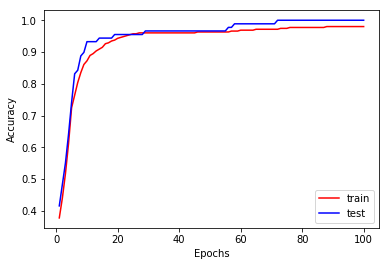

In [17]:
plt.plot(np.arange(len(stats['train_accuracy']))+1, stats['train_accuracy'], color='red', label='train')
plt.plot(np.arange(len(stats['test_accuracy']))+1, stats['test_accuracy'], color='blue', label='test')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0,0.5,'loss')

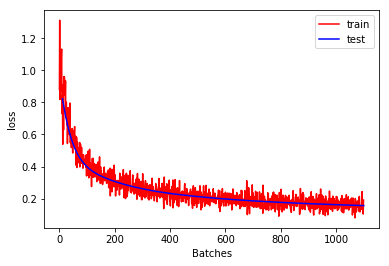

In [18]:
ratio = len(stats['train_loss']) / len(stats['test_loss']) 
plt.plot(np.arange(len(stats['train_loss'])), stats['train_loss'], color='red', label='train')
plt.plot(np.arange(1, len(stats['test_loss'])+1)*ratio, stats['test_loss'], color='blue', label='test')
plt.legend(loc='best')
plt.xlabel('Batches')
plt.ylabel('loss')

## Tensorflow

In this section we implement the same NN in tensorflow.

In [19]:
import tensorflow as tf
tfk = tf.keras

build the model

In [20]:
tfmodel = tfk.Sequential()
tfmodel.add(tfk.Input(shape=(2)))
for i in range(nLayers):
    tfmodel.add(tfk.layers.Dense(nHidden, activation=act))
tfmodel.add(tfk.layers.Dense(nClasses))
loss_fn = tfk.losses.SparseCategoricalCrossentropy(from_logits=True)
tfmodel.compile(optimizer=tfk.optimizers.SGD(learning_rate=lr), 
                loss=loss_fn,
                metrics = ['accuracy'])

have a look at the model

In [21]:
tfmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 322
Trainable params: 322
Non-trainable params: 0
_________________________________________________________________


train the model

In [22]:
history = tfmodel.fit(x, y.argmax(-1), epochs=100,
            batch_size=bSize, validation_split = 0.2)

Epoch 1/100
11/11 [==============================] - 0s 18ms/step - loss: 0.9619 - accuracy: 0.5455 - val_loss: 0.8710 - val_accuracy: 0.5393
Epoch 2/100
11/11 [==============================] - 0s 3ms/step - loss: 0.8485 - accuracy: 0.5455 - val_loss: 0.7710 - val_accuracy: 0.5393
Epoch 3/100
11/11 [==============================] - 0s 3ms/step - loss: 0.7514 - accuracy: 0.5455 - val_loss: 0.6870 - val_accuracy: 0.5393
Epoch 4/100
11/11 [==============================] - 0s 3ms/step - loss: 0.6697 - accuracy: 0.5511 - val_loss: 0.6179 - val_accuracy: 0.6180
Epoch 5/100
11/11 [==============================] - 0s 3ms/step - loss: 0.6032 - accuracy: 0.5966 - val_loss: 0.5619 - val_accuracy: 0.6517
Epoch 6/100
11/11 [==============================] - 0s 3ms/step - loss: 0.5505 - accuracy: 0.6847 - val_loss: 0.5172 - val_accuracy: 0.7079
Epoch 7/100
11/11 [==============================] - 0s 3ms/step - loss: 0.5084 - accuracy: 0.7557 - val_loss: 0.4815 - val_accuracy: 0.8427
Epoch 8/100


Epoch 59/100
11/11 [==============================] - 0s 2ms/step - loss: 0.1935 - accuracy: 0.9972 - val_loss: 0.1881 - val_accuracy: 1.0000
Epoch 60/100
11/11 [==============================] - 0s 4ms/step - loss: 0.1922 - accuracy: 0.9972 - val_loss: 0.1869 - val_accuracy: 1.0000
Epoch 61/100
11/11 [==============================] - 0s 3ms/step - loss: 0.1910 - accuracy: 0.9972 - val_loss: 0.1858 - val_accuracy: 1.0000
Epoch 62/100
11/11 [==============================] - 0s 3ms/step - loss: 0.1897 - accuracy: 0.9972 - val_loss: 0.1846 - val_accuracy: 1.0000
Epoch 63/100
11/11 [==============================] - 0s 3ms/step - loss: 0.1886 - accuracy: 0.9972 - val_loss: 0.1835 - val_accuracy: 1.0000
Epoch 64/100
11/11 [==============================] - 0s 3ms/step - loss: 0.1874 - accuracy: 0.9972 - val_loss: 0.1824 - val_accuracy: 1.0000
Epoch 65/100
11/11 [==============================] - 0s 4ms/step - loss: 0.1863 - accuracy: 0.9972 - val_loss: 0.1813 - val_accuracy: 1.0000
Epoch 

have a look at the metrics

In [23]:
stats = history.history

Text(0,0.5,'Accuracy')

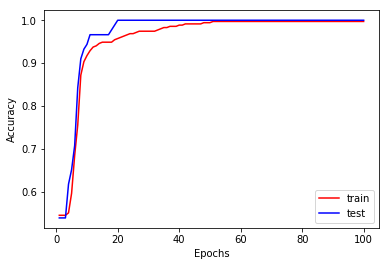

In [24]:
plt.plot(np.arange(len(stats['accuracy']))+1, stats['accuracy'], color='red', label='train')
plt.plot(np.arange(len(stats['val_accuracy']))+1, stats['val_accuracy'], color='blue', label='test')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

## Exercises

Pen and Paper:
1. Convince yourself of the equations in the slides. Add the missing indices?
2. Compute $\partial_j J$ for the crossentropy loss in the case of softmax and logistic in the last layer. Eq (28) and (32) in the slides.

Deep Learning exercises:
1. Implement more activation functions, such as leaky relu or tanh
2. Use logistic/sigmoid in the last layer since we only have a 2 Classes classification problem.

Physics exercises:
1. Predict Hodge numbers; Data can be created with pyCICY package, but is also found in the github repository.
    1. as Classification problem, with e.g. five classes being: $h^1 = {0,1,2,3,>3}$.
    2. as Regression problem, $h^1 \in \mathbb{Z}_{\ge 0}$. Reproduce results of Fabians paper.

## Hodge numbers of line bundles

Hodge numbers of line bundles were one of the [first](https://arxiv.org/pdf/1706.07024.pdf) applications of ML techniques. Neural networks tend to have a harder time in regression problems and often do significantly better in classification problems. Thus, in [later](https://arxiv.org/pdf/1809.02547.pdf) [developments](https://arxiv.org/pdf/1906.08730.pdf) the focus was to identify polynomial cones of the hodge numbers.

I've still got some data from our polynomial [paper](https://arxiv.org/pdf/1906.00392.pdf) where we used conventional curve fitting to identify the cones and their analytic expressions.

You are welcome to use the data and reproduce these papers.

In [25]:
import pandas as pd

In [26]:
h7806 = pd.read_csv('data/hodge/7806.csv', sep=' ', index_col=0)
h7806

,m0,m1,h0,h1,h2,h3
0,-10.0,-10.0,0.0,0.0,0.0,4060
1,-10.0,-9.0,0.0,0.0,0.0,3215
2,-10.0,-8.0,0.0,0.0,0.0,2484
3,-10.0,-7.0,0.0,0.0,0.0,1861
4,-10.0,-6.0,0.0,0.0,0.0,1340
...,...,...,...,...,...,...
436,10.0,6.0,1340.0,0.0,0.0,0
437,10.0,7.0,1861.0,0.0,0.0,0
438,10.0,8.0,2484.0,0.0,0.0,0
439,10.0,9.0,3215.0,0.0,0.0,0


In [27]:
h7882 = pd.read_csv('data/hodge/7882.csv', sep=' ', index_col=0)
h7882

,m0,m1,h0,h1,h2,h3
0,-10.0,-10.0,0.0,0.0,0.0,3730
1,-10.0,-9.0,0.0,0.0,0.0,2975
2,-10.0,-8.0,0.0,0.0,0.0,2316
3,-10.0,-7.0,0.0,0.0,0.0,1749
4,-10.0,-6.0,0.0,0.0,0.0,1270
...,...,...,...,...,...,...
436,10.0,6.0,1270.0,0.0,0.0,0
437,10.0,7.0,1749.0,0.0,0.0,0
438,10.0,8.0,2316.0,0.0,0.0,0
439,10.0,9.0,2975.0,0.0,0.0,0
